# Lab 2 (Treebased Classifier)

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download("words")
from nltk.corpus import words
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import gensim
from gensim.models import Word2Vec
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from nltk.probability import FreqDist

nltk.download("omw-1.4")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package words to /Users/pnawn/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/pnawn/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/pnawn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pnawn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/pnawn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_excel("GL dataset.xlsx")
df.head()

,lineDescription,localAmount,PostDate,Group Acctnum
0,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",3080.0,2015-01-08,32
1,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",-1780.0,2015-01-08,62
2,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",-700.0,2015-01-08,62
3,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",-600.0,2015-01-08,62
4,"Reverses ""AL- ACCR- ELECTRICITY CHRGS FOR DEC ...",4000.0,2015-01-08,32


## Data Preprocessing

In [3]:
df = df.groupby("Group Acctnum").filter(lambda x: len(x) >= 12)

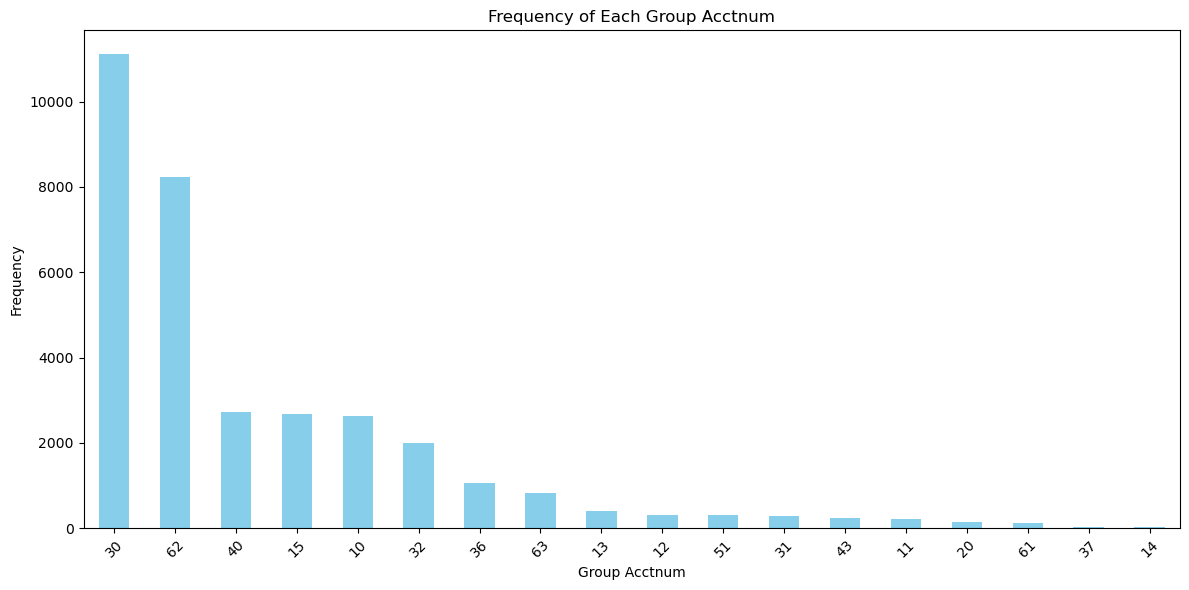

In [4]:
group_acctnum_counts = df["Group Acctnum"].value_counts()

plt.figure(figsize=(12, 6))
group_acctnum_counts.plot(kind="bar", color="skyblue")
plt.title("Frequency of Each Group Acctnum")
plt.xlabel("Group Acctnum")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [5]:
df["day_range"] = df["PostDate"].dt.day.apply(lambda x: 0 if x <= 10 else (1 if x <= 20 else 2))

In [6]:
df["is_dr"] = df["localAmount"].apply(lambda x: 1 if x >= 0 else 0)

In [7]:
df.loc[df["Group Acctnum"] == 30, "lineDescription"] = df["lineDescription"] + " payable"

In [8]:
import string

string.punctuation


def remove_punctuation(text):
    punctutationfree = "".join([i for i in text if i not in string.punctuation])
    return punctutationfree


df["LiDesc_clean"] = df["lineDescription"].apply(lambda x: remove_punctuation(x))
df.head()

,lineDescription,localAmount,PostDate,Group Acctnum,day_range,is_dr,LiDesc_clean
0,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",3080.0,2015-01-08,32,0,1,Reverses AL ACCR RECURRING CHARGES FOR DEC 201...
1,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",-1780.0,2015-01-08,62,0,0,Reverses AL ACCR RECURRING CHARGES FOR DEC 201...
2,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",-700.0,2015-01-08,62,0,0,Reverses AL ACCR RECURRING CHARGES FOR DEC 201...
3,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",-600.0,2015-01-08,62,0,0,Reverses AL ACCR RECURRING CHARGES FOR DEC 201...
4,"Reverses ""AL- ACCR- ELECTRICITY CHRGS FOR DEC ...",4000.0,2015-01-08,32,0,1,Reverses AL ACCR ELECTRICITY CHRGS FOR DEC 201...


In [9]:
df["LiDesc_clean"] = df["LiDesc_clean"].str.lower()

In [10]:
# define function for tokenization


def tokenization(text):
    tokens = word_tokenize(text)
    return tokens


df["LiDesc_clean"] = df["LiDesc_clean"].apply(lambda x: tokenization(x))

In [11]:
# remove stop words

stopwords = nltk.corpus.stopwords.words("english")
stopwords[0:10]
if "other" in stopwords:
    stopwords.remove("other")

# define function to remove stopwords from tokenized text


def remove_stopwords(text):
    output = [i for i in text if i not in stopwords]
    return output


df["LiDesc_clean"] = df["LiDesc_clean"].apply(lambda x: remove_stopwords(x))

In [12]:
df["LiDesc_clean"] = df["LiDesc_clean"].apply(lambda words: [word for word in words if len(word) > 2])

In [13]:
# defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()


# defining the function for lemmatization
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text


df["LiDesc_clean"] = df["LiDesc_clean"].apply(lambda x: lemmatizer(x))

In [14]:
english_words = set(words.words())


def filter_non_dictionary_words(text):
    # Ensure the text is a list of words
    if isinstance(text, str):
        text = word_tokenize(text)

    return [word for word in text if word.lower() in english_words]


df["LiDesc_clean"] = df["LiDesc_clean"].apply(lambda x: filter_non_dictionary_words(x))

In [15]:
df = df.query("LiDesc_clean != ''")

## Split train test

In [16]:
df["LiDesc_clean"] = df["LiDesc_clean"].str.join(" ")

In [17]:
X = df.drop(columns=["Group Acctnum"])
y = df["Group Acctnum"]

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_transformed = vectorizer.fit_transform(X_train["LiDesc_clean"])

In [20]:
X_test_transformed = vectorizer.transform(X_test["LiDesc_clean"])

In [21]:
tfidf_df = pd.DataFrame(X_transformed.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,access,accident,accommodation,account,accretion,accrual,accrue,acquired,acquisition,acrylic,...,wrong,wrongly,yan,yang,year,yee,yen,young,yr,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.443081,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [22]:
# Combine matrix for X_train
other_features = csr_matrix(X_train[["is_dr", "day_range"]].values)
combined_matrix = hstack([X_transformed, other_features])

In [23]:
# Combine matrix for X_test
other_features_X_test = csr_matrix(X_test[["is_dr", "day_range"]].values)
combined_matrix_X_test = hstack([X_test_transformed, other_features_X_test])

In [24]:
X_train = combined_matrix
X_test = combined_matrix_X_test

## Construct Decision Tree (w/GridSearchCV)

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [26]:
DT = DecisionTreeClassifier(random_state=42)
parameters = {"max_depth": list(range(40, 66)), "min_samples_split": list(range(2, 11))}
DT_GCV = GridSearchCV(DT, parameters)
DT_GCV.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                                       50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
                                       60, 61, 62, 63, 64, 65],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [27]:
pd.DataFrame(DT_GCV.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
103,0.125679,0.003115,0.001488,0.000045,51,6,"{'max_depth': 51, 'min_samples_split': 6}",0.867104,0.876476,0.874203,0.878703,0.873828,0.874063,0.003895,1
90,0.129255,0.003269,0.001439,0.000010,50,2,"{'max_depth': 50, 'min_samples_split': 2}",0.867854,0.874414,0.873828,0.879265,0.874391,0.873950,0.003629,2
139,0.129399,0.003685,0.001482,0.000014,55,6,"{'max_depth': 55, 'min_samples_split': 6}",0.867854,0.874227,0.874016,0.879828,0.872891,0.873763,0.003814,3
100,0.128724,0.003348,0.001457,0.000032,51,3,"{'max_depth': 51, 'min_samples_split': 3}",0.866917,0.875914,0.873641,0.878515,0.873828,0.873763,0.003850,4
136,0.132726,0.003857,0.001495,0.000029,55,3,"{'max_depth': 55, 'min_samples_split': 3}",0.867854,0.874227,0.874391,0.879078,0.873078,0.873725,0.003584,5


In [28]:
print(DT_GCV.best_params_)

{'max_depth': 51, 'min_samples_split': 6}


In [29]:
DT_BEST = DT_GCV.best_estimator_
DT_BEST

DecisionTreeClassifier(max_depth=51, min_samples_split=6, random_state=42)

In [30]:
DT_BEST_y_pred = DT_BEST.predict(X_test)

In [31]:
print(classification_report(y_test, DT_BEST_y_pred))

              precision    recall  f1-score   support

          10       0.94      0.94      0.94       525
          11       0.59      0.88      0.70        42
          12       0.68      0.82      0.74        62
          13       0.67      0.46      0.54        81
          14       1.00      1.00      1.00         4
          15       0.79      0.54      0.64       536
          20       0.87      0.62      0.73        32
          30       1.00      1.00      1.00      2222
          31       0.77      0.83      0.80        59
          32       0.87      0.66      0.75       398
          36       0.71      0.64      0.67       214
          37       0.57      0.80      0.67         5
          40       0.96      0.96      0.96       543
          43       0.96      0.88      0.92        50
          51       0.79      0.53      0.63        62
          61       0.20      0.04      0.07        23
          62       0.78      0.94      0.85      1645
          63       0.85    

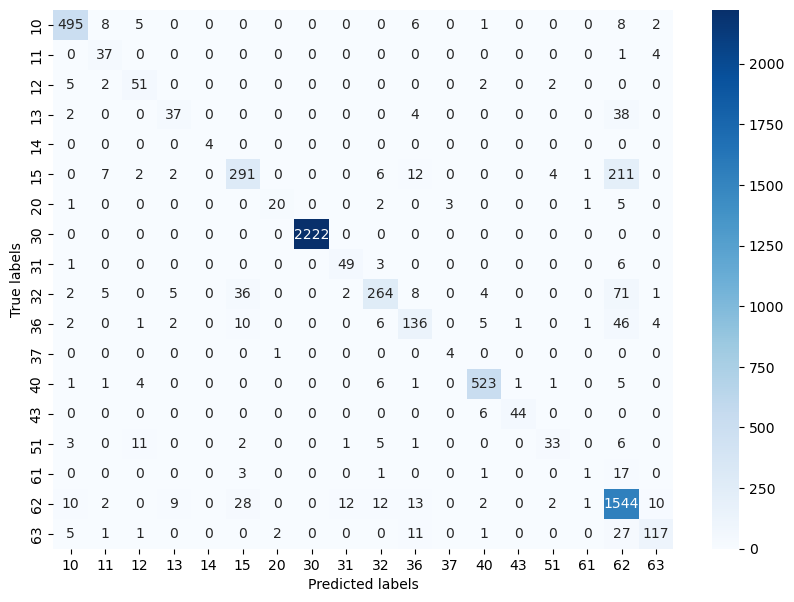

In [32]:
unique_labels = sorted(np.unique(np.concatenate([y_test, DT_BEST_y_pred])))
# Compute confusion matrix with explicit labels
lr_cm = confusion_matrix(y_test, DT_BEST_y_pred, labels=unique_labels)
# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(lr_cm, annot=True, fmt="g", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

## Construct Random Forest Tree (w/GridSearchCV)

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
RF_EST = RandomForestClassifier(
    random_state=42,
)

parameters = {
    "max_depth": [30, 40, 50],
    "min_samples_split": [2, 4, 7],
    "n_estimators": [200, 300, 400, 500, 600],
    "max_features": [400, 800],
}
print(np.prod([len(v) for v in parameters.values()]))

RF_GCV = GridSearchCV(RF_EST, parameters, verbose=10, n_jobs=6)
RF_GCV.fit(X_train, y_train)

90
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5; 1/90] START max_depth=30, max_features=400, min_samples_split=2, n_estimators=200
[CV 3/5; 1/90] START max_depth=30, max_features=400, min_samples_split=2, n_estimators=200
[CV 2/5; 1/90] START max_depth=30, max_features=400, min_samples_split=2, n_estimators=200
[CV 4/5; 1/90] START max_depth=30, max_features=400, min_samples_split=2, n_estimators=200
[CV 5/5; 1/90] START max_depth=30, max_features=400, min_samples_split=2, n_estimators=200
[CV 1/5; 2/90] START max_depth=30, max_features=400, min_samples_split=2, n_estimators=300
[CV 1/5; 1/90] END max_depth=30, max_features=400, min_samples_split=2, n_estimators=200;, score=0.869 total time=   9.1s
[CV 2/5; 2/90] START max_depth=30, max_features=400, min_samples_split=2, n_estimators=300
[CV 2/5; 1/90] END max_depth=30, max_features=400, min_samples_split=2, n_estimators=200;, score=0.873 total time=   9.1s
[CV 3/5; 1/90] END max_depth=30, max_features=400, min

/opt/homebrew/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5; 5/90] END max_depth=30, max_features=400, min_samples_split=2, n_estimators=600;, score=0.875 total time=  27.4s
[CV 4/5; 6/90] START max_depth=30, max_features=400, min_samples_split=4, n_estimators=200
[CV 3/5; 6/90] START max_depth=30, max_features=400, min_samples_split=4, n_estimators=200
[CV 2/5; 6/90] END max_depth=30, max_features=400, min_samples_split=4, n_estimators=200;, score=0.874 total time=   8.8s
[CV 5/5; 6/90] START max_depth=30, max_features=400, min_samples_split=4, n_estimators=200
[CV 3/5; 5/90] END max_depth=30, max_features=400, min_samples_split=2, n_estimators=600;, score=0.879 total time=  27.1s
[CV 1/5; 7/90] START max_depth=30, max_features=400, min_samples_split=4, n_estimators=300
[CV 4/5; 5/90] END max_depth=30, max_features=400, min_samples_split=2, n_estimators=600;, score=0.880 total time=  27.4s
[CV 4/5; 6/90] END max_depth=30, max_features=400, min_samples_split=4, n_estimators=200;, score=0.880 total time=   8.9s
[CV 2/5; 7/90] START max_d

GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=6,
             param_grid={'max_depth': [30, 40, 50], 'max_features': [400, 800],
                         'min_samples_split': [2, 4, 7],
                         'n_estimators': [200, 300, 400, 500, 600]},
             verbose=10)

In [79]:
pd.DataFrame(RF_GCV.cv_results_).sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
74,36.391394,0.166677,0.340330,0.002132,50,400,7,600,"{'max_depth': 50, 'max_features': 400, 'min_sa...",0.873664,0.880787,0.885077,0.886014,0.881890,0.881487,0.004364,1
65,10.194980,0.104030,0.114998,0.000843,50,400,4,200,"{'max_depth': 50, 'max_features': 400, 'min_sa...",0.875726,0.879475,0.883202,0.888076,0.879640,0.881224,0.004163,2
73,25.395751,1.696430,0.292419,0.015329,50,400,7,500,"{'max_depth': 50, 'max_features': 400, 'min_sa...",0.873102,0.880412,0.884702,0.885827,0.881890,0.881187,0.004480,3
72,19.531256,0.190113,0.228199,0.000852,50,400,7,400,"{'max_depth': 50, 'max_features': 400, 'min_sa...",0.873102,0.880412,0.884514,0.886202,0.881702,0.881187,0.004527,3
70,9.786415,0.097862,0.120437,0.012840,50,400,7,200,"{'max_depth': 50, 'max_features': 400, 'min_sa...",0.873852,0.880600,0.884889,0.886202,0.880390,0.881187,0.004328,5
69,30.400806,0.195122,0.344898,0.002986,50,400,4,600,"{'max_depth': 50, 'max_features': 400, 'min_sa...",0.874039,0.879850,0.884327,0.885827,0.880577,0.880924,0.004106,6
67,20.387962,0.137346,0.229302,0.001440,50,400,4,400,"{'max_depth': 50, 'max_features': 400, 'min_sa...",0.874227,0.879850,0.883202,0.886389,0.880765,0.880887,0.004027,7
60,10.797685,0.061208,0.115716,0.001413,50,400,2,200,"{'max_depth': 50, 'max_features': 400, 'min_sa...",0.875539,0.879475,0.883202,0.886014,0.879640,0.880774,0.003570,8
68,25.364613,0.182984,0.289776,0.003019,50,400,4,500,"{'max_depth': 50, 'max_features': 400, 'min_sa...",0.874039,0.879663,0.884139,0.885452,0.880202,0.880699,0.004002,9
71,14.617487,0.076764,0.171733,0.001412,50,400,7,300,"{'max_depth': 50, 'max_features': 400, 'min_sa...",0.872165,0.881350,0.883202,0.886389,0.880015,0.880624,0.004740,10


In [80]:
print(RF_GCV.best_params_)

{'max_depth': 50, 'max_features': 400, 'min_samples_split': 7, 'n_estimators': 600}


In [81]:
RF_BEST = RF_GCV.best_estimator_
RF_BEST

RandomForestClassifier(max_depth=50, max_features=400, min_samples_split=7,
                       n_estimators=600, random_state=42)

In [82]:
RF_BEST_y_pred = RF_BEST.predict(X_test)

In [83]:
print(classification_report(y_test, RF_BEST_y_pred))

              precision    recall  f1-score   support

          10       0.95      0.94      0.95       525
          11       0.59      0.88      0.70        42
          12       0.65      0.82      0.72        62
          13       0.72      0.41      0.52        81
          14       1.00      1.00      1.00         4
          15       0.85      0.54      0.66       536
          20       0.91      0.66      0.76        32
          30       1.00      1.00      1.00      2222
          31       0.82      0.83      0.82        59
          32       0.91      0.67      0.77       398
          36       0.72      0.67      0.70       214
          37       0.57      0.80      0.67         5
          40       0.97      0.95      0.96       543
          43       1.00      0.88      0.94        50
          51       0.82      0.50      0.62        62
          61       0.75      0.13      0.22        23
          62       0.77      0.96      0.86      1645
          63       0.88    

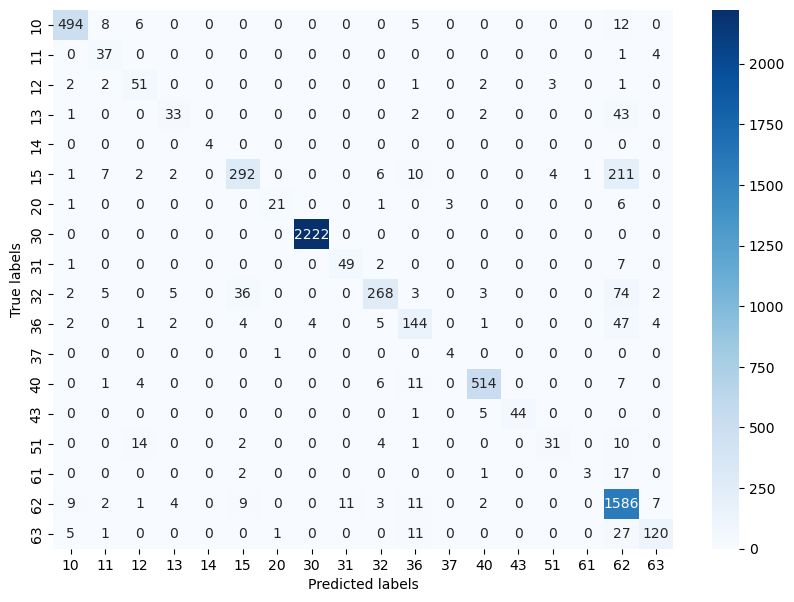

In [84]:
unique_labels = sorted(np.unique(np.concatenate([y_test, RF_BEST_y_pred])))
# Compute confusion matrix with explicit labels
lr_cm = confusion_matrix(y_test, RF_BEST_y_pred, labels=unique_labels)
# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(lr_cm, annot=True, fmt="g", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()